## Wrong lengths

This script processes the csv file including all the lengths and detects(fixes?) thw wrongly created lengths in cases such as:

- 1 real length recorded as 2 lengths (it should be merged)
- 2 real lengths recorded as 1 length (it should be splited)
- Merge consecutive RESTs

How to approach it?
- Compute global stats (mean, mode, ...) of time and strokes and compare each length to detect wrong ones?
- Anomaly detection techniques?

In [92]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
# read the csv file with lengths data
lengths_original = pd.read_csv('lengths.csv')

### Identify unusual sets

In [ ]:
# read the csv file with sets data
sets_original = pd.read_csv('sets.csv')

In [62]:
# identify sets with unusual distances (125m, 75m...)
sets_original['unusual_set_distance'] = sets_original.apply(
    lambda x: (str(x['distance'])[-2:] in ('25', '75')) and (x['distance'] != 25),
    axis=1
)
unusual_sets = sets_original[sets_original['unusual_set_distance'] == True]
print(len(unusual_sets))
#unusual_sets[['datetime', 'interval', 'style', 'distance']]

58


### Gaussian Anomaly Detection

In [94]:
# drop rest&drill rows (to avoid disturbing the time and strokes stats)
lengths = lengths_original.drop(lengths_original[\
                                                 (lengths_original['style'] == 'REST') |\
                                                 (lengths_original['style'] == 'DRILL')
                                                ].index)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122ee65f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1242ffb38>]], dtype=object)

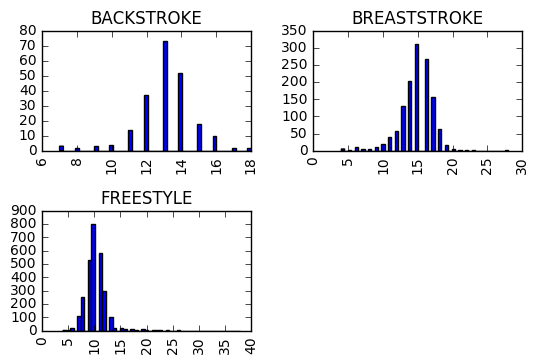

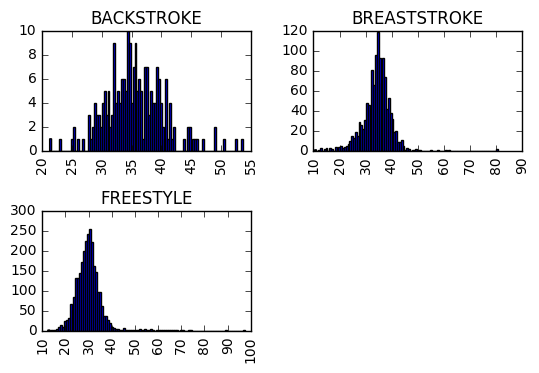

In [95]:
# visually check gaussianity of 'time' and 'strokes'
lengths.hist(column='strokes', by='style', bins=50)
lengths.hist(column='time', by='style', bins=100)

In [148]:
# select only a single style and length distance
lengths_style = lengths[(lengths['style'] == 'BREASTSTROKE') & (lengths['distance'] == 25)]

In [149]:
# normalize time and strokes features
time_mu = np.mean(lengths_style['time'])
time_sigma = np.std(lengths_style['time'])
lengths_style.loc[:,'time_n'] = lengths_style.apply(
    lambda x: (x['time'] - time_mu)/time_sigma, axis=1
)
strokes_mu = np.mean(lengths_style['strokes'])
strokes_sigma = np.std(lengths_style['strokes'])
lengths_style.loc[:,'strokes_n'] = lengths_style.apply(
    lambda x: (x['strokes'] - strokes_mu)/strokes_sigma, axis=1
)

/Users/eduard/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/eduard/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [150]:
# function to compute p(x) of N(m,s)
def normpdf(x, mean, sd):
    var = float(sd)**2
    pi = 3.1415926
    denom = (2*pi*var)**.5
    num = exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [151]:
# compute p(x)
lengths_style.loc[:,'time_p(x)'] = lengths_style.apply(
    lambda x: normpdf(x['time'], time_mu, time_sigma),
    axis=1
)
lengths_style.loc[:,'strokes_p(x)'] = lengths_style.apply(
    lambda x: normpdf(x['strokes'], strokes_mu, strokes_sigma),
    axis=1
)
lengths_style['p(x)'] = lengths_style['time_p(x)'] * lengths_style['strokes_p(x)']

/Users/eduard/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/eduard/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/eduard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [156]:
# see basic stats for wrong_manual = True / False
lengths_style[lengths_style['wrong_manual'] == True].describe()

,interval,length,distance,time,strokes,time_n,strokes_n,time_p(x),strokes_p(x),p(x)
count,16.000000,16.000000,16.0,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,1.600000e+01
mean,3.500000,4.625000,25.0,17.386188,6.562500,-3.101659,-3.604526,0.002899,0.002896,3.349886e-05
std,4.258325,3.556684,0.0,4.182566,1.896268,0.758619,0.816773,0.005236,0.006123,8.492169e-05
min,1.000000,1.000000,25.0,10.437000,4.000000,-4.362078,-4.708262,0.000005,0.000003,1.409683e-11
25%,1.000000,2.000000,25.0,14.718750,6.000000,-3.585470,-3.846809,0.000117,0.000105,1.230153e-08
50%,2.000000,3.500000,25.0,16.937500,6.000000,-3.183040,-3.846809,0.000470,0.000105,7.891202e-08
75%,3.250000,6.000000,25.0,18.718250,7.250000,-2.860054,-3.308401,0.001222,0.000875,2.887191e-06
max,14.000000,13.000000,25.0,24.620000,10.000000,-1.789615,-2.123903,0.014589,0.018012,2.627825e-04


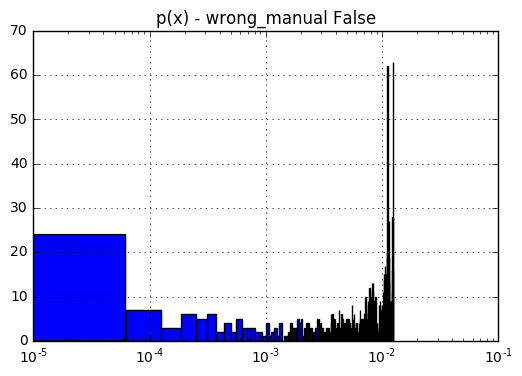

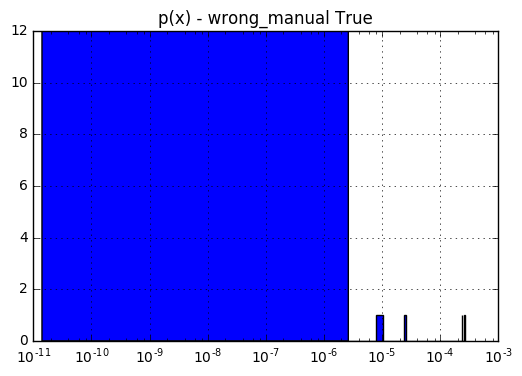

In [157]:
# plot a histogram of p(x) for wrong_manual = True / False
fig, axes = plt.subplots()
lengths_style[lengths_style['wrong_manual'] == False].hist(ax=axes, column='p(x)', bins=200)
axes.set_xscale('log')
axes.set_title('p(x) - wrong_manual False')
#axes.set_xlim(0.00001,0.1)

fig, axes = plt.subplots()
lengths_style[lengths_style['wrong_manual'] == True].hist(ax=axes, column='p(x)', bins=100)
axes.set_xscale('log')
axes.set_title('p(x) - wrong_manual True')
#axes.set_xlim(0.00001,0.1)

In [154]:
lengths_style[lengths_style['p(x)'] <= 0.0001].describe()

/Users/eduard/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,interval,length,distance,time,strokes,time_n,strokes_n,time_p(x),strokes_p(x),p(x)
count,40.000000,40.000000,41.0,41.000000,41.000000,41.000000,41.000000,4.100000e+01,4.100000e+01,4.100000e+01
mean,4.275000,6.525000,25.0,28.534366,10.585366,-1.079641,-1.871771,1.853275e-03,9.736973e-03,1.079251e-05
std,4.157092,7.031021,0.0,19.457793,7.151838,3.529186,3.080486,2.769086e-03,3.030318e-02,2.297906e-05
min,1.000000,1.000000,25.0,10.437000,4.000000,-4.362078,-4.708262,4.091058e-17,2.260671e-08,9.248538e-25
25%,NaN,NaN,25.0,16.312000,6.000000,-3.296491,-3.846809,7.447015e-05,1.051427e-04,1.156574e-08
50%,NaN,NaN,25.0,19.625000,7.000000,-2.695591,-3.416083,5.857841e-04,5.024412e-04,1.173950e-07
75%,NaN,NaN,25.0,46.812000,15.000000,2.235492,0.029729,2.707630e-03,5.639562e-03,4.922363e-06
max,16.000000,36.000000,25.0,80.687000,28.000000,8.379621,5.629174,1.237366e-02,1.717591e-01,9.293399e-05
